In [13]:
%matplotlib inline
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
import sklearn
import seaborn as sns
import geopandas as gpd
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn import datasets, cluster, metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder

In [14]:
print("Python:", sys.version[:5])
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Seaborn:", scipy.__version__)
print("GeoPandas:", gpd.__version__)
print("SciPy:", scipy.__version__)

Python: 3.7.0
Pandas: 0.23.4
Numpy: 1.15.3
Matplotlib: 3.0.1
Scikit-learn: 0.20.0
Seaborn: 1.1.0
GeoPandas: 0.3.0
SciPy: 1.1.0


In [3]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
prices_folder = Path("data/")
cols_2excl = ['CLASS', 'STNO', 'STnu', 'FLATPOSN', 'YEAR OF SALE (BUSINESS)', 'RPI', 'DEFLATOR', 'OMIT OR USE']
new_cols = ['street', 'postcode', 'sale_month', 'sale_year', 'sale_date', 'sale_quarter', 'nominal_price',
            'july_2013_price', 'buyer_origin', 'build', 'local_housing_forum']

fp = "/home/david/Desktop/Personal/University/CS982/Assignment/alternative_data/2011_Census_Glasgow_City_(shp)/DZ_2011_EoR_Glasgow_City.shp"
map_df = gpd.read_file(fp)

In [4]:
map_df.head()

,GSS_CODEDZ,DZ_Name,GSS_CODECA,CA_Name,GSS_CODEIZ,geometry
0,S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,..."
1,S01003026,None,S12000046,Glasgow_City,S02000584,"POLYGON ((258523 659616, 258532 659448, 258583..."
2,S01003027,None,S12000046,Glasgow_City,S02000587,"POLYGON ((254367.8425000003 658647.1636999995,..."
3,S01003028,None,S12000046,Glasgow_City,S02000585,"POLYGON ((260169 658643, 260179 658592, 260209..."
4,S01003029,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259204 658200, 259174 658180, 259164..."


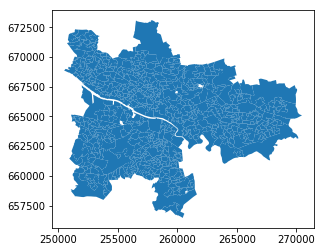

In [5]:
map_df.plot()

In [6]:
def concatenate(folder):
    file_list = folder.glob("*.csv")  # Find .csv files
    df_list = []
    for file_name in file_list:
        single_df = pd.read_csv(file_name, low_memory=False)
        clean_df = single_df[:-1]  # Remove last row of each CSV file as it's not relevant
        df_list.append(clean_df)
    df = pd.concat(df_list, axis=0, sort=False)  # Concatenate CSV files
    df.drop(columns=cols_2excl, inplace=True)  # Drop useless columns
    df.columns = new_cols  # Rename columns with code-friendly terms
    # Regular Expression to convert date formats from YYYY-MM-DD to YYYY-MM as DD was always 01 anyway
    df.sale_date = df.sale_date.str.replace(r'-\d{2}$', r'', regex=True)
    # Regular Expression to convert date formats from DD/MM/YYYY to YYYY-MM
    df.sale_date = df.sale_date.str.replace(r'\d{2}\/(\d{2})\/(\d{4})$', r'\2-\1', regex=True)
    # print(df.iloc[96165]['july_2013_price']) # 2000
    return df

In [7]:
def from_xls():
    xls = pd.ExcelFile('data/datazones.xls')
    dz_df = pd.read_excel(xls, 'Sheet1')
    dz_df = dz_df[['Postcode', 'DataZone']]
    dz_df.columns = ['postcode', 'datazone']
    return dz_df

In [8]:
def merge_df(simd_df, left_df, column, year, first):
    new_col = ''.join(column + '_' + str(year))
    right_df = simd_df[['Datazone', new_col]]
    right_df.columns = ['datazone', column]
    right_df['sale_year'] = year
    merged_df = pd.merge(left_df, right_df, how='left', on=['datazone', 'sale_year'])
    dupl_col_x = ''.join(column + '_x')
    dupl_col_y = ''.join(column + '_y')
    if not first:
        merged_df[column] = merged_df[dupl_col_x].fillna(merged_df[dupl_col_y])
        merged_df.drop(columns=[dupl_col_x, dupl_col_y], inplace=True)
    return merged_df

In [9]:
def create_pdf_fig(filename):
    pwd = os.path.abspath(os.path.dirname(sys.argv[0]))
    graph_path = os.path.join(pwd, '{}.pdf'.format(filename))
    pdf = PdfPages(graph_path)
    plt.savefig(pdf, format='pdf', bbox_inches='tight')
    plt.show()
    pdf.close()
    pdf = None

In [10]:
dataframe = concatenate(prices_folder)
datazone_df = from_xls()

merged = pd.merge(dataframe, datazone_df, on='postcode')

In [11]:
overall_simd_df = pd.read_csv('data/simd/simd-overall-2004-2012-glasgow-v2.csv')
employ_simd_df = pd.read_csv('data/simd/simd-employment-2004-2012-glasgow-v2.csv')
income_simd_df = pd.read_csv('data/simd/simd-income-2004-2012-glasgow-v2.csv')
health_simd_df = pd.read_csv('data/simd/simd-health-2004-2012-glasgow-v2.csv')
edu_simd_df = pd.read_csv('data/simd/simd-education-2004-2012-glasgow-v2.csv')
geo_simd_df = pd.read_csv('data/simd/simd-geographic-access-2004-2012-glasgow-v2.csv')
housing_simd_df = pd.read_csv('data/simd/simd-housing-2004-2012-glasgow-v2.csv')
crime_simd_df = pd.read_csv('data/simd/simd-crime-2006-2012-glasgow-v2.csv')

overall_col = 'overall_deprivation_rank'
overall_04 = merge_df(overall_simd_df, merged, overall_col, 2004, True)
overall_06 = merge_df(overall_simd_df, overall_04, overall_col, 2006, False)
overall_09 = merge_df(overall_simd_df, overall_06, overall_col, 2009, False)
overall_12 = merge_df(overall_simd_df, overall_09, overall_col, 2012, False)

empl_col = 'employment_deprivation_rank'
empl_04 = merge_df(employ_simd_df, overall_12, empl_col, 2004, True)
empl_06 = merge_df(employ_simd_df, empl_04, empl_col, 2006, False)
empl_09 = merge_df(employ_simd_df, empl_06, empl_col, 2009, False)
empl_12 = merge_df(employ_simd_df, empl_09, empl_col, 2012, False)

income_col = 'income_deprivation_rank'
income_04 = merge_df(income_simd_df, empl_12, income_col, 2004, True)
income_06 = merge_df(income_simd_df, income_04, income_col, 2006, False)
income_09 = merge_df(income_simd_df, income_06, income_col, 2009, False)
income_12 = merge_df(income_simd_df, income_09, income_col, 2012, False)

health_col = 'health_deprivation_rank'
health_04 = merge_df(health_simd_df, income_12, health_col, 2004, True)
health_06 = merge_df(health_simd_df, health_04, health_col, 2006, False)
health_09 = merge_df(health_simd_df, health_06, health_col, 2009, False)
health_12 = merge_df(health_simd_df, health_09, health_col, 2012, False)

edu_col = 'education_deprivation_rank'
edu_04 = merge_df(edu_simd_df, health_12, edu_col, 2004, True)
edu_06 = merge_df(edu_simd_df, edu_04, edu_col, 2006, False)
edu_09 = merge_df(edu_simd_df, edu_06, edu_col, 2009, False)
edu_12 = merge_df(edu_simd_df, edu_09, edu_col, 2012, False)

geo_col = 'geographic_access_deprivation_rank'
geo_04 = merge_df(geo_simd_df, edu_12, geo_col, 2004, True)
geo_06 = merge_df(geo_simd_df, geo_04, geo_col, 2006, False)
geo_09 = merge_df(geo_simd_df, geo_06, geo_col, 2009, False)
geo_12 = merge_df(geo_simd_df, geo_09, geo_col, 2012, False)

housing_col = 'housing_deprivation_rank'
housing_04 = merge_df(housing_simd_df, geo_12, housing_col, 2004, True)
housing_06 = merge_df(housing_simd_df, housing_04, housing_col, 2006, False)
housing_09 = merge_df(housing_simd_df, housing_06, housing_col, 2009, False)
housing_12 = merge_df(housing_simd_df, housing_09, housing_col, 2012, False)

crime_col = 'crime_deprivation_rank'
crime_06 = merge_df(crime_simd_df, housing_12, crime_col, 2006, True)
crime_09 = merge_df(crime_simd_df, crime_06, crime_col, 2009, False)
crime_12 = merge_df(crime_simd_df, crime_09, crime_col, 2012, False)

df = crime_12

In [12]:
df = df.sort_values(by=['sale_date', 'july_2013_price'], ascending=False)
df = df[['street', 'postcode', 'datazone', 'local_housing_forum', overall_col, empl_col, income_col,
                     health_col, edu_col, geo_col, housing_col, crime_col, 'sale_date', 'sale_quarter',
                     'sale_year', 'sale_month', 'nominal_price', 'july_2013_price', 'build', 'buyer_origin']]

In [13]:
df.local_housing_forum = df.local_housing_forum.str.replace(' ', '_')
df = pd.get_dummies(df, columns=['build'], drop_first=True)
df = pd.get_dummies(df, columns=['local_housing_forum'])

df = df[pd.notnull(df['crime_deprivation_rank'])]               # Drop NaN rows, keeps 2006, 2009, 2012 only
df.drop(columns='nominal_price', inplace=True)

In [14]:
df = df.rename(index=str, columns={"build_RESALE": "resale",
                                      "local_housing_forum_Baillieston_Shettleston": "Baillieston_Shettleston",
                                      "local_housing_forum_Drumchapel_Anniesland_and_Garscadden_Scotstounhill": "Drumchapel_Anniesland_Garscadden_Scotstounhill",
                                      "local_housing_forum_East_Centre_and_Calton": "East_Centre_Calton",
                                      "local_housing_forum_Central_and_West": "Central_West",
                                      "local_housing_forum_Govan_and_Craigton": "Govan_Craigton",
                                      "local_housing_forum_Greater_Pollok_and_Newlands_Auldburn": "Greater_Pollok_Newlands_Auldburn",
                                      "local_housing_forum_Langside_and_Linn": "Langside_Linn",
                                      "local_housing_forum_Maryhill_Kelvin_and_Canal": "Maryhill_Kelvin_Canal",
                                      "local_housing_forum_Pollokshields_and_Southside_Central": "Pollokshields_Southside_Central",
                                      "local_housing_forum_Springburn": "Springburn",
                                      "sale_month": "month", "sale_year": "year", "sale_quarter":"quarter", "sale_date":"date",
                                      "crime_deprivation_rank":"crime", "housing_deprivation_rank":"housing",
                                      "geographic_access_deprivation_rank":"geographic_access", "education_deprivation_rank":"education",
                                      "health_deprivation_rank":"health", "income_deprivation_rank":"income",
                                      "employment_deprivation_rank":"employment", "overall_deprivation_rank":"overall",
                                      "july_2013_price":"price"})

In [15]:
df_for_map = df[['datazone','price','overall','employment','income','health','education','geographic_access','housing','crime','year','month','resale']]
df_for_map.head()

,datazone,price,overall,employment,income,health,education,geographic_access,housing,crime,year,month,resale
82784,S01003453,925751.62,4924.0,4904.0,4597.0,5883.0,2905.0,5991.0,519.0,2642.0,2012,12.0,1
61074,S01003597,740601.30,5841.0,5409.0,5990.0,4259.0,5792.0,3694.0,4794.0,3535.0,2012,12.0,1
76796,S01003545,682931.52,6356.0,5687.0,5949.0,6467.0,6000.0,5921.0,1442.0,4281.0,2012,12.0,1
46540,S01003257,627285.25,3387.0,4364.0,2582.0,4200.0,2915.0,1962.0,1019.0,3990.0,2012,12.0,1
23603,S01003025,624502.94,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012,12.0,1


In [16]:
merged_map = map_df.set_index('GSS_CODEDZ').join(df_for_map.set_index('datazone'))
merged_map.head()

,DZ_Name,GSS_CODECA,CA_Name,GSS_CODEIZ,geometry,price,overall,employment,income,health,education,geographic_access,housing,crime,year,month,resale
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",624502.94,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012.0,12.0,1.0
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",152504.07,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012.0,11.0,1.0
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",254173.45,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012.0,10.0,1.0
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",454375.52,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012.0,6.0,1.0
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",489103.09,4963.0,4834.0,4776.0,5194.0,5828.0,1176.0,4157.0,4491.0,2012.0,4.0,1.0


In [17]:
# variable = 'price'
# vmin, vmax = 0, 1

# # create figure and axes for Matplotlib
# fig, ax = plt.subplots(1, figsize=(10, 6))

# merged_map.plot(column=variable, cmap='YlGn', ax=ax,
#             linewidth=0.1, edgecolor='0.5', scheme='equal_interval',
#             k=15)

# ax.axis('off')
# ax.set_title('Glasgow Overall SIMD', \
#               fontdict={'fontsize': '25',
#                         'fontweight' : '3'})

# # create an annotation for the  data source
# ax.annotate('Source: Glasgow Open Data, 2014',
#            xy=(0.1, .08), xycoords='figure fraction',
#            horizontalalignment='left', verticalalignment='top',
#            fontsize=10, color='#555555')

# # Create colorbar as a legend
# sm = plt.cm.ScalarMappable(cmap='YlGn')
# sm._A = []
# cbar = fig.colorbar(sm)

# # this will save the figure as a high-res png. you can also save as svg
# # fig.savefig('testmap.png', dpi=800)

In [18]:
df.datazone = df.datazone.str.replace(r'S\d{5}', r'', regex=True)
df.datazone = df.datazone.apply(pd.to_numeric)
print(df.dtypes)

street                                             object
postcode                                           object
datazone                                            int64
overall                                           float64
employment                                        float64
income                                            float64
health                                            float64
education                                         float64
geographic_access                                 float64
housing                                           float64
crime                                             float64
date                                               object
quarter                                            object
year                                                int64
month                                             float64
price                                             float64
buyer_origin                                       object
resale        

In [19]:
df.overall = df.overall/6505
df.employment = df.employment/6505
df.income = df.income/6505
df.health = df.health/6505
df.education = df.education/6505
df.geographic_access = df.geographic_access/6505
df.housing = df.housing/6505
df.crime = df.crime/6505

In [20]:
# print("Find most important features relative to target")
# # df = df.pivot(columns='overall', values='price')
# corr = df.corr()
# fig = plt.figure()
# overall1 = sns.heatmap(corr)
# fig.savefig('overall1.pdf', bbox_inches="tight")
# corr.sort_values(["overall"], ascending = False, inplace = True)
# print(corr.overall)

In [21]:
df = df[['price','datazone','overall','employment','income','health','education','geographic_access','housing','crime',
         'month','resale','buyer_origin']]

In [22]:
# corr = df.corr()
# fig = plt.figure()
# overall2 = sns.heatmap(corr)
# corr.sort_values(["overall"], ascending = False, inplace = True)
# fig.savefig('overall2.pdf', bbox_inches="tight")
# print(corr.overall)

In [23]:
print(df.shape)
# df = pd.get_dummies(df, columns=['buyer_origin'])
# df = pd.get_dummies(df, columns=['datazone'])
le = LabelEncoder()
df['buyer_origin'] = le.fit_transform(df['buyer_origin'].astype(str))

(30651, 13)


In [24]:
df.head()

,price,datazone,overall,employment,income,health,education,geographic_access,housing,crime,month,resale,buyer_origin
82784,925751.62,453,0.756956,0.753882,0.706687,0.904381,0.446580,0.920984,0.079785,0.406149,12.0,1,633
61074,740601.30,597,0.897925,0.831514,0.920830,0.654727,0.890392,0.567871,0.736972,0.543428,12.0,1,633
76796,682931.52,545,0.977095,0.874251,0.914527,0.994158,0.922367,0.910223,0.221676,0.658109,12.0,1,633
46540,627285.25,257,0.520676,0.670869,0.396925,0.645657,0.448117,0.301614,0.156649,0.613374,12.0,1,633
23603,624502.94,25,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,12.0,1,368


In [25]:
target = df.values[:, 0]
attributes = df.values[:, 1:]

In [26]:
print(df.values)

[[9.25751620e+05 4.53000000e+02 7.56956188e-01 ... 1.20000000e+01
  1.00000000e+00 6.33000000e+02]
 [7.40601300e+05 5.97000000e+02 8.97924673e-01 ... 1.20000000e+01
  1.00000000e+00 6.33000000e+02]
 [6.82931520e+05 5.45000000e+02 9.77094543e-01 ... 1.20000000e+01
  1.00000000e+00 6.33000000e+02]
 ...
 [2.37240800e+04 5.19000000e+02 3.85857033e-02 ... 1.00000000e+00
  1.00000000e+00 6.33000000e+02]
 [2.32399200e+04 3.51000000e+02 8.73174481e-02 ... 1.00000000e+00
  1.00000000e+00 6.33000000e+02]
 [2.25943600e+04 2.08000000e+02 2.61337433e-03 ... 1.00000000e+00
  1.00000000e+00 6.33000000e+02]]


In [27]:
print(df.values.shape)

(30651, 13)


In [28]:
# scaled = scale(attributes)
scaler = StandardScaler()
scaler.fit(attributes)
scaled_attributes = scaler.transform(attributes)

In [29]:
scaler.fit(df.values)
scaled_full = scaler.transform(df.values)

In [30]:
print(scaled_attributes)

[[ 0.46693479  1.29978689  1.27095985 ...  1.49623243  0.42112351
  -0.21626187]
 [ 1.2261044   1.79907142  1.55252666 ...  1.49623243  0.42112351
  -0.21626187]
 [ 0.95195982  2.07947657  1.7075278  ...  1.49623243  0.42112351
  -0.21626187]
 ...
 [ 0.81488753 -1.24454961 -1.32224262 ... -1.76037458  0.42112351
  -0.21626187]
 [-0.07081035 -1.0719507  -0.78865957 ... -1.76037458  0.42112351
  -0.21626187]
 [-0.82470794 -1.371957   -1.44769318 ... -1.76037458  0.42112351
  -0.21626187]]


In [31]:
print(scaled_full)

[[ 7.74375476  0.46693479  1.29978689 ...  1.49623243  0.42112351
  -0.21626187]
 [ 5.87319838  1.2261044   1.79907142 ...  1.49623243  0.42112351
  -0.21626187]
 [ 5.29056598  0.95195982  2.07947657 ...  1.49623243  0.42112351
  -0.21626187]
 ...
 [-1.36934519  0.81488753 -1.24454961 ... -1.76037458  0.42112351
  -0.21626187]
 [-1.37423661 -0.07081035 -1.0719507  ... -1.76037458  0.42112351
  -0.21626187]
 [-1.38075865 -0.82470794 -1.371957   ... -1.76037458  0.42112351
  -0.21626187]]


In [86]:
pca = PCA(n_components=12)
pca.fit(scaled_attributes)

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

[0.4537945  0.56355992 0.65038026 0.73476916 0.81712748 0.89400802
 0.93639237 0.96998765 0.98839967 0.9954109  0.99964893 1.        ]


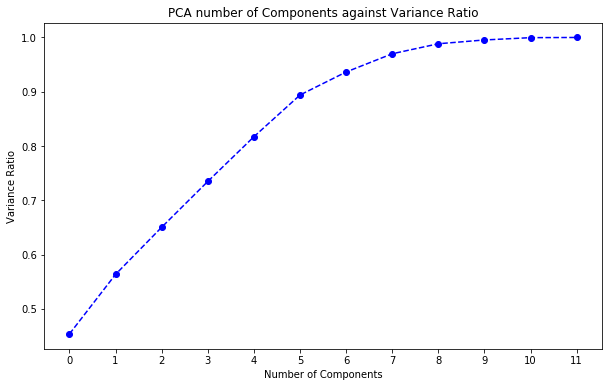

In [96]:
var_ratio = pca.explained_variance_ratio_.cumsum()
print(var_ratio)
fig = plt.figure(figsize=(10,6))
plt.title('PCA number of Components against Variance Ratio')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 13, step=1))
plt.ylabel('Variance Ratio')
plt.plot(var_ratio, '--bo')
fig.savefig('pca_components_variance.pdf', bbox_inches="tight")

In [33]:
# n_samples, n_features = scaled_attributes.shape
# n_digits = len(np.unique(target))
# # encoded_target = LabelEncoder().fit_transform(target)
# model = cluster.AgglomerativeClustering(n_clusters=n_digits, linkage="ward", affinity="euclidean")
# model.fit(scaled_attributes)

# # print(encoded_outcome)
# print("length:", n_digits)
# print("n samples:", n_samples, "n features:", n_features)

# # print(model.labels_)
# print(metrics.silhouette_score(scaled_attributes, model.labels_))
# print(metrics.completeness_score(target, model.labels_))
# print(metrics.homogeneity_score(target, model.labels_))

In [34]:
model = linkage(scaled_attributes, 'complete')
fig = plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram (Complete)')
plt.xlabel('Distance')
plt.ylabel('Sample Index')
dendrogram(
        model,
        p=20,
        truncate_mode='lastp',
        orientation='right',
    )
fig.savefig('dendro_ward_comple.pdf', bbox_inches="tight")

MemoryError: unable to allocate array data.

In [ ]:
print(attributes[5589])

In [ ]:
df.iloc[[5589]]
# print(df.values[6740])
# print(vg_sales.as_matrix()[3568])
# print(df.values[1876])
# print(vg_sales.as_matrix()[3568])

In [ ]:
df.iloc[[2526]]

In [ ]:
print(df.info())

In [ ]:
fig = plt.figure(figsize=(50,50))
plt.title('this is test')
plt.xlabel('x test')
plt.ylabel('y test')
df.overall.plot(kind='box', subplots=True)
fig.savefig('test.pdf', bbox_inches="tight")

In [ ]:
df.price.plot(kind='box')
create_pdf_fig('price_box')